<h1> Imports

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFdr
from scipy.signal import butter, lfilter, filtfilt, freqz
from scipy import signal
import pywt

<h1> Fitlering Functions

In [2]:
def apply_butterband_filter(input_df):
    df = input_df.copy()
    for col in df.columns:
        df[col] = filter_df_col(df, col)
        
    return df

def filter_df_col(df, col):
    fs = 512.0
    lowcut = 12.0
    highcut = 25.0
    
    vals = df[col].values
    return butter_bandpass_filter(vals, lowcut, highcut, fs)

def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    data = data * 50    # amplify data
    y = filtfilt(b, a, data)
    return y

In [102]:
def wavelet_dwt(df):
    return pywt.dwt2(df.values, 'db4')

def pca_and_inverse(df):
    pca = PCA(0.95).fit(df)
    components = pca.transform(df)
    return pca.inverse_transform(components)
    
def pca_feature_selection(df):
    pca = PCA(1).fit(df)
    return pca.transform(df)

In [103]:
record_export_folder = 'EEG_Recordings'
keep_cols = ['EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8'] # ['Timestamp', 'EEG.Counter', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']

def load_df(file_name):
    file_path = os.path.join(record_export_folder, file_name)
    return pd.read_csv(file_path, skiprows=0, header=1)

def trim_cols(df):
    return df[keep_cols]

def filter_data(df):
#     df = apply_butterband_filter(df)
    return wavelet_dwt(df)

In [114]:
df = trim_cols(load_df('sultan_checkerboard_{}.csv'.format(1)))
approx, decomp = filter_data(df)
decomp = np.asarray(decomp)

In [115]:
print(approx.shape)
print(decomp.shape)

(1939, 5)
(3, 1939, 5)


<h1> Data from 4 Sensors

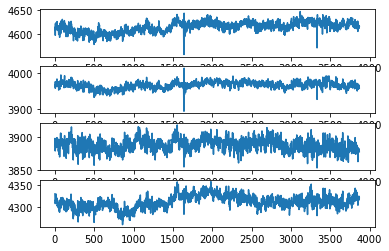

In [116]:
subplot = 0
fig, axs = plt.subplots(4)
for col in df.columns:
    axs[subplot].plot(df[col].values)
    subplot += 1

<h1> Wavlet Decomposition 

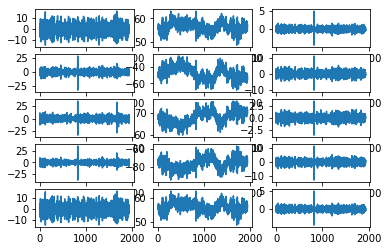

In [120]:
bands = approx.shape[1]
subplot = 0
axis = 0
fig, axs = plt.subplots(bands, 3)
for axis in [0,1,2]:
    for col in range(decomp.shape[2]):
        axs[subplot, axis].plot(dataset[axis,:,col])
        subplot += 1
    subplot = 0

TypeError: tuple indices must be integers or slices, not tuple

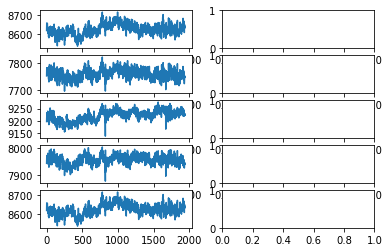

In [110]:
bands = approx.shape[1]
subplot = 0
axis = 0
fig, axs = plt.subplots(bands, 2)
for dataset in [approx, decomp]:
    for col in range(bands):
        axs[subplot, axis].plot(dataset[:,col])
        subplot += 1
    subplot = 0
    axis += 1

<h1> PCA Seperating Approx and Discrete

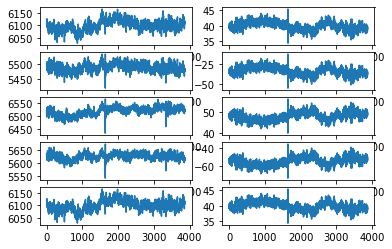

In [58]:
bands = approx.shape[1]
subplot = 0
axis = 0
pca_approx = pca_and_inverse(approx) 
pca_decomp = pca_and_inverse(decomp)
fig, axs = plt.subplots(bands, 2)
for dataset in [pca_approx, pca_decomp]:
    for col in range(bands):
        axs[subplot, axis].plot(dataset[:,col])
        subplot += 1
    subplot = 0
    axis += 1

<h1> PCA

In [62]:
subplot = 0
axis = 0
full = np.concatenate((approx, decomp), axis=1)
pca_full = pca_and_inverse(full)
bands = pca_full.shape[1]

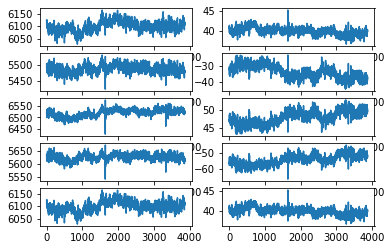

In [63]:
fig, axs = plt.subplots(int(bands / 2), 2)
for col in range(bands):
    axs[subplot, axis].plot(pca_full[:,col])
    subplot += 1
    if subplot == int(bands / 2):
        subplot = 0
        axis += 1

<h1> Training Data

In [74]:
seconds_to_check = 1
interval_range = int(128 * seconds_to_check)
data_points = int(30 / seconds_to_check)

def split_to_training_data(df):
    total_data = []
    for interval_start in range(0, interval_range * data_points, interval_range):
        temp_data = []
        for col in range(0, df.shape[1]):
            temp_data.append(df[interval_start:interval_start + interval_range, col])
        
        total_data.append(temp_data)
        
    return np.asarray(total_data)

def create_target_data(data, target):
    return np.asarray([target] * data.shape[0])

In [75]:
from tensorflow.keras.utils import to_categorical

In [89]:
targets = range(1, 9)
total_train_x = []
total_train_y = []
for target in targets:
    df = trim_cols(load_df('sultan_checkerboard_{}.csv'.format(target)))
    approx, decomp = filter_data(df)
    pca_approx = pca_and_inverse(approx) 
    pca_decomp = pca_and_inverse(decomp)
    filtered_df = np.concatenate((pca_approx, pca_decomp), axis=1)
    filtered_df = pca_approx
    train_x = split_to_training_data(filtered_df)
    train_y = create_target_data(train_x, target - 1)
    if target == 1:
        total_train_x = train_x
        total_train_y = train_y
    else:
        total_train_x = np.concatenate((total_train_x, train_x))
        total_train_y = np.concatenate((total_train_y, train_y))

In [90]:
# targets = range(1, 9)
# total_train_x = []
# total_train_y = []
# for target in targets:
#     df = trim_cols(load_df('sultan_checkerboard_{}.csv'.format(target)))
#     filtered_df = filter_data(df)
#     train_x = split_to_training_data(filtered_df)
#     train_y = create_target_data(train_x, target - 1)
#     if target == 1:
#         total_train_x = train_x
#         total_train_y = train_y
#     else:
#         total_train_x = np.concatenate((total_train_x, train_x))
#         total_train_y = np.concatenate((total_train_y, train_y))

In [91]:
# total_train_y = to_categorical(total_train_y, num_classes=8)

In [92]:
total_train_x.shape

(240, 5, 128)

In [93]:
# total_train_x = total_train_x.reshape(total_train_x.shape[0], -1)

In [94]:
train_x, validation_x, train_y, validation_y = train_test_split(total_train_x, total_train_y, test_size = 0.2)

In [95]:
from sklearn.svm import LinearSVC, SVC

In [96]:
# svc = LinearSVC()
# svc.fit(train_x, train_y)

In [97]:
# svc.score(validation_x, validation_y)

In [98]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU, BatchNormalization, LayerNormalization, ActivityRegularization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

In [99]:
def create_model():
    model = Sequential()
    model.add(LSTM(16, input_shape=(train_x.shape[1:]), return_sequences=True))
    model.add(Dropout(0.25))
    model.add(ActivityRegularization(l2=0.01))
    model.add(BatchNormalization())

    model.add(LSTM(16, input_shape=(train_x.shape[1:]), return_sequences=False))
    model.add(Dropout(0.25))
    model.add(ActivityRegularization(l2=0.01))
    model.add(BatchNormalization())

    model.add(Dense(16))

    model.add(Dense(8, activation="softmax"))
    
    return model

In [100]:
EPOCHS = 100
BATCH_SIZE = 16
NAME= "models\BEST"

In [101]:
model = create_model()
    
opt = tf.keras.optimizers.Adam()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt, metrics=['acc'])

callbacks = [
    #TensorBoard(f"logs\{RATIO_TO_PREDICT}-VOLUME-{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"),
#     ReduceLROnPlateau(patience=10, factor=0.1),
#     EarlyStopping(patience=12),
#     ModelCheckpoint(filepath=NAME, monitor='val_loss', verbose=2, save_weights_only=True, save_best_only=True, mode='min')
]
    
history = model.fit(train_x,
                    train_y,
                    batch_size= BATCH_SIZE,
                    epochs = EPOCHS,
                    validation_data=(validation_x, validation_y), 
                    callbacks=callbacks)

Epoch 1/100
12/12 [==============================] - 1s 113ms/step - loss: 2.6198 - acc: 0.1510 - val_loss: 2.2967 - val_acc: 0.1458
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 2.6339 - acc: 0.0938 - val_loss: 2.2895 - val_acc: 0.1458
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 2.6645 - acc: 0.0938 - val_loss: 2.2892 - val_acc: 0.1458
Epoch 4/100
12/12 [==============================] - 0s 7ms/step - loss: 2.5736 - acc: 0.1146 - val_loss: 2.2878 - val_acc: 0.1458
Epoch 5/100
12/12 [==============================] - 0s 7ms/step - loss: 2.4317 - acc: 0.1771 - val_loss: 2.2874 - val_acc: 0.1458
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 2.4759 - acc: 0.1302 - val_loss: 2.2882 - val_acc: 0.1458
Epoch 7/100
12/12 [==============================] - 0s 7ms/step - loss: 2.5100 - acc: 0.1302 - val_loss: 2.2894 - val_acc: 0.1042
Epoch 8/100
12/12 [==============================] - 0s 7ms/step - loss: 2.4324 -

Epoch 63/100
12/12 [==============================] - 0s 7ms/step - loss: 2.3378 - acc: 0.1198 - val_loss: 2.2921 - val_acc: 0.0833
Epoch 64/100
12/12 [==============================] - 0s 6ms/step - loss: 2.3444 - acc: 0.1719 - val_loss: 2.2925 - val_acc: 0.0833
Epoch 65/100
12/12 [==============================] - 0s 6ms/step - loss: 2.3544 - acc: 0.1302 - val_loss: 2.2936 - val_acc: 0.0833
Epoch 66/100
12/12 [==============================] - 0s 6ms/step - loss: 2.3629 - acc: 0.1354 - val_loss: 2.2929 - val_acc: 0.0833
Epoch 67/100
12/12 [==============================] - 0s 7ms/step - loss: 2.3791 - acc: 0.1094 - val_loss: 2.2924 - val_acc: 0.0833
Epoch 68/100
12/12 [==============================] - 0s 8ms/step - loss: 2.3586 - acc: 0.1250 - val_loss: 2.2924 - val_acc: 0.0833
Epoch 69/100
12/12 [==============================] - 0s 10ms/step - loss: 2.3707 - acc: 0.1354 - val_loss: 2.2915 - val_acc: 0.0833
Epoch 70/100
12/12 [==============================] - 0s 7ms/step - loss: 2